## Population Disaggregation 

In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
import rasterio
import numpy as np
import pickle
import pandas as pd
import geopandas
import xarray
import matplotlib.pyplot as plt
import shapely
from to_degree import to_degree
from region_new import Region
from region_new.region import regions_from_cities
from region_new.equations import *

In [2]:
# bounding boxes and FUA's
bounding_box = json.load(open('bounding_box.json'))
# MS buildings for each city
ordu_house = os.path.join("data","ml","prediction", "type", "Ordu.pkl")
adana_house = os.path.join("data","ml","prediction", "type", "Adana.pkl")
manisa_house = os.path.join("data","ml","prediction", "type", "Manisa.pkl")
trabzon_house = os.path.join("data","ml","prediction", "type", "Trabzon.pkl")

In [3]:
cities = dict(
    Ordu = dict ( box= bounding_box['Ordu']['box'], fua= bounding_box['Ordu']['fua'], name= 'Ordu', house= ordu_house ),
    Adana = dict( box= bounding_box["Adana"]["box"], fua= bounding_box["Adana"]["fua"], name = "Adana", house = adana_house ),
    Manisa = dict( box= bounding_box["Manisa"]["box"], fua= bounding_box["Manisa"]["fua"], name = "Manisa", house = manisa_house ),
    Trabzon = dict( box= bounding_box["Trabzon"]["box"], fua= bounding_box["Trabzon"]["fua"], name = "Trabzon", house = trabzon_house )
)

In [34]:
def gpw_to_coarse_pop(raster_path, city):
    path = raster_path+city+'.tif'
    result = xarray.open_rasterio(path)
    with rasterio.Env():
        with rasterio.open(path) as src:
            data = src.read(1)
            data = np.where(data == np.nan, 0, data)
            data = np.where(data < 0, 0, data)
            region = np.unique(data)
            counts = [np.count_nonzero(data==region[i]) for i in range(len(region))]
            for i in range(len(region)):
                data = np.where(data==region[i], region[i]*counts[i], data)
    result['coarse_pop'] = (('y','x'),data)
    result.rio.write_crs(4326, inplace=True)
    result.coarse_pop.rio.to_raster( os.path.join("data","coarse_pop", city+".tif") )

In [ ]:
gpw_path = os.path.join('data', 'gpw', '')
for city in cities:
    print(city)
    gpw_to_coarse_pop(gpw_path, city)

## Population Disaggregation
We test two distributions against each other at various resolutions.  
We either disaggregate population given the building volume -- *area x density x height* --  
or given the building surface only -- *area x density*.

#### BUILT-S-RES vs OURS

250 

100 



<Figure size 640x480 with 0 Axes>

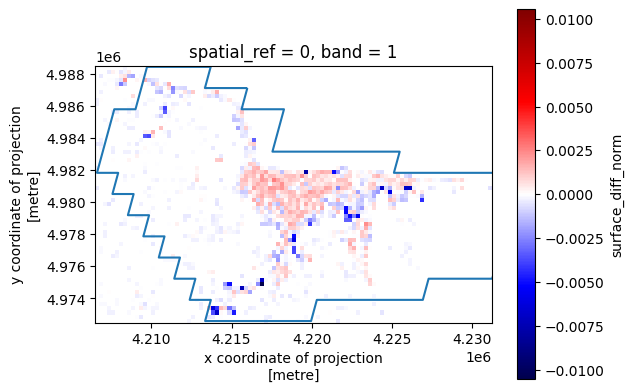

<Figure size 640x480 with 0 Axes>

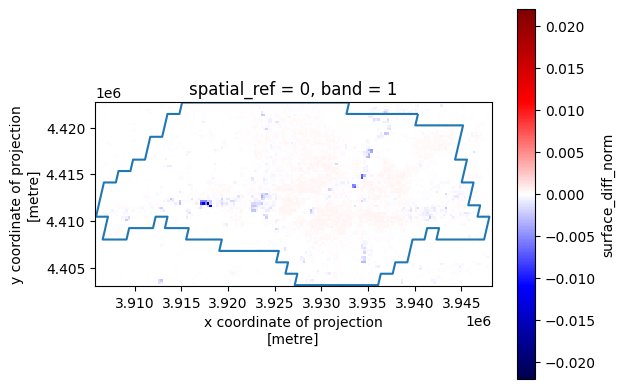

<Figure size 640x480 with 0 Axes>

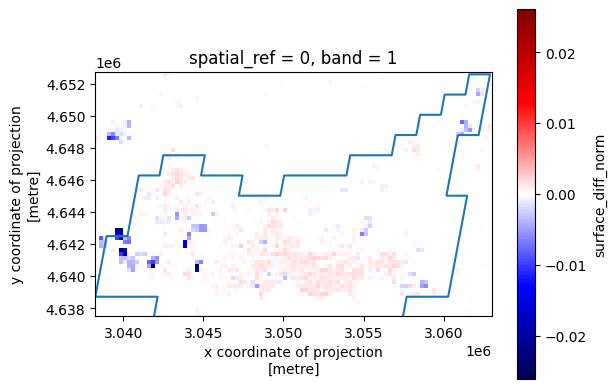

<Figure size 640x480 with 0 Axes>

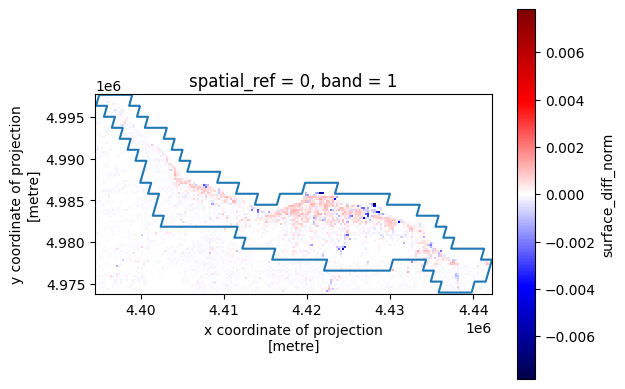

<Figure size 640x480 with 0 Axes>

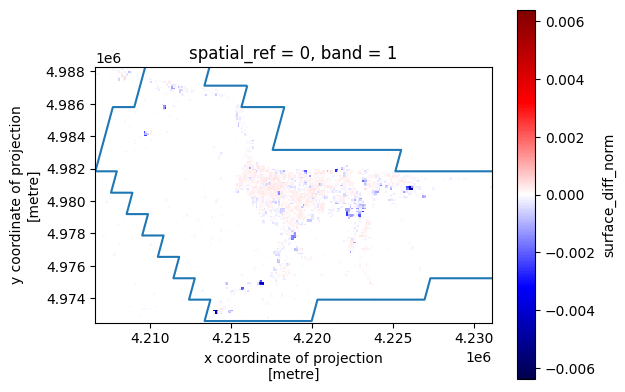

<Figure size 640x480 with 0 Axes>

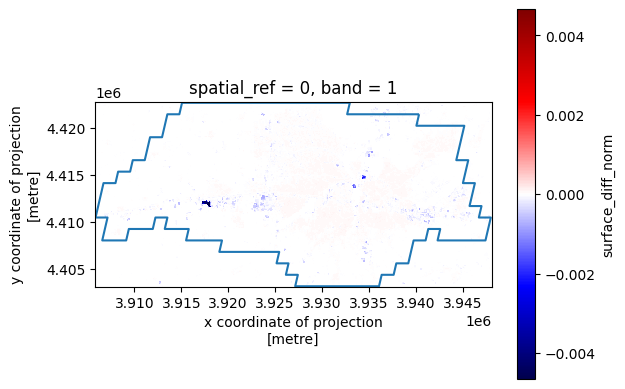

<Figure size 640x480 with 0 Axes>

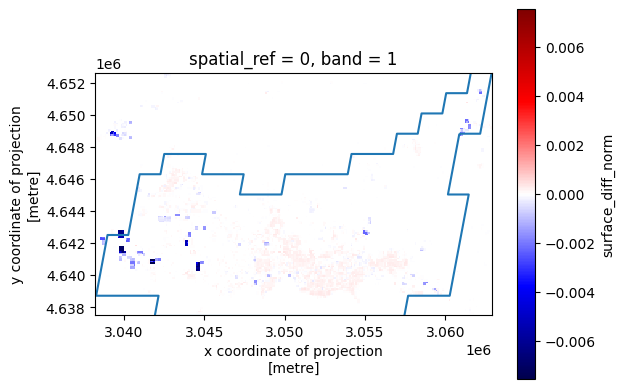

<Figure size 640x480 with 0 Axes>

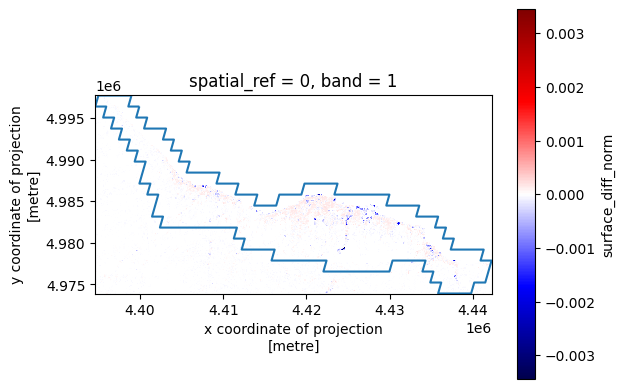

In [8]:
resolutions = [250, 100]
for r in resolutions:
    print(r, '\n')
    Cities = regions_from_cities(cities, r)
    for city in Cities:
        region = Cities[city]
        # BUILT-S DIFF
        # We normalize because Building fraction and surface dont share the same unit
        region.normalize_variable('res', output=True)
        region.normalize_variable('surface', output=True)
        region.output = region.output.assign(surface_diff_norm = region.output['res'] - region.output['surface'])
        plt.figure()
        ax=region.vector['fua'].geo_df.exterior.plot(alpha=1)
        region.output['surface_diff_norm'].plot(ax=ax, cmap="seismic")

#### POP_S vs POP_v

500 

Ordu 500 1439.0436660486578
Adana 500 927.7747045629627
Manisa 500 3832.7812796655776
Trabzon 500 918.6344291027649
250 

Ordu 250 519.9952544400718
Adana 250 371.4067956210565
Manisa 250 1020.344078018432
Trabzon 250 341.59982523237517
100 

Ordu 100 91.76799497158504
Adana 100 61.56290216005687
Manisa 100 239.6735122527931


/tmp/ipykernel_38342/4061208381.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Trabzon 100 53.36234625885597
50 

Ordu 50 23.747763265800035
Adana 50 19.17962963586371
Manisa 50 67.08761315100712
Trabzon 50 17.587830557446317


<Figure size 640x480 with 0 Axes>

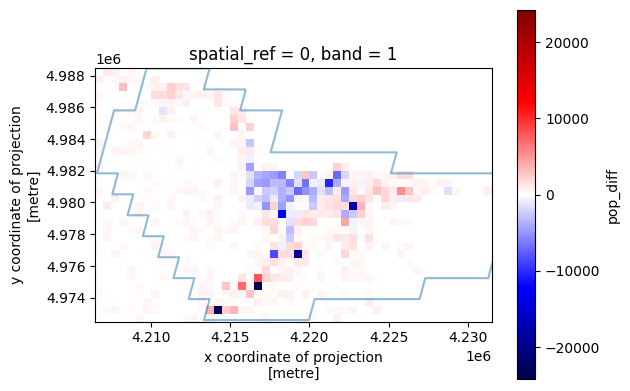

<Figure size 640x480 with 0 Axes>

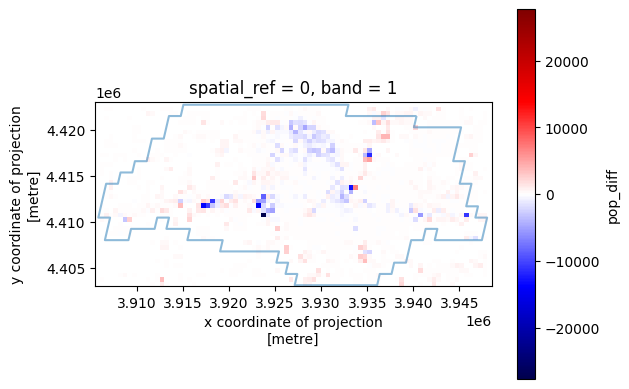

<Figure size 640x480 with 0 Axes>

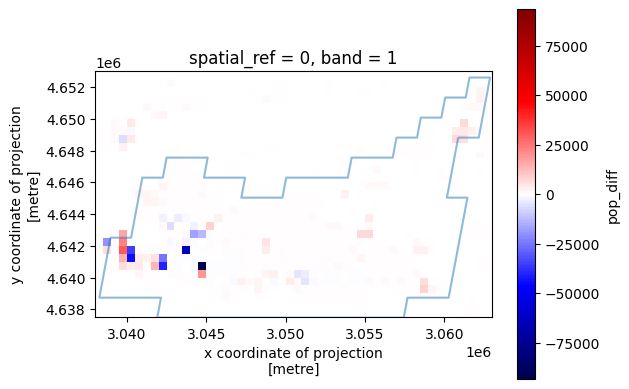

<Figure size 640x480 with 0 Axes>

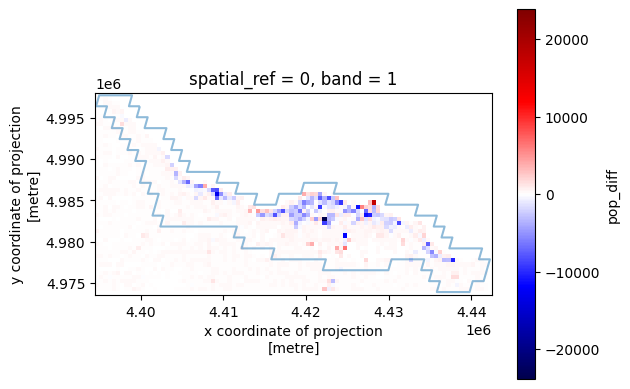

<Figure size 640x480 with 0 Axes>

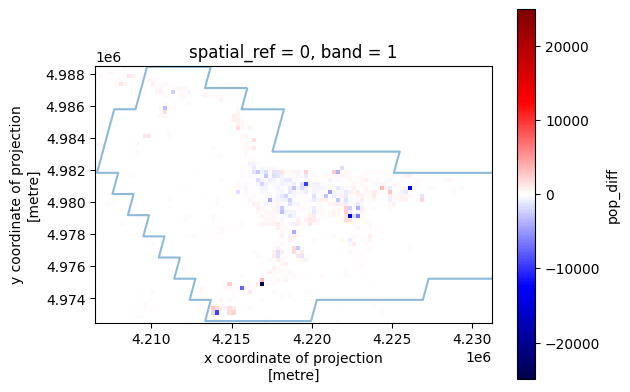

<Figure size 640x480 with 0 Axes>

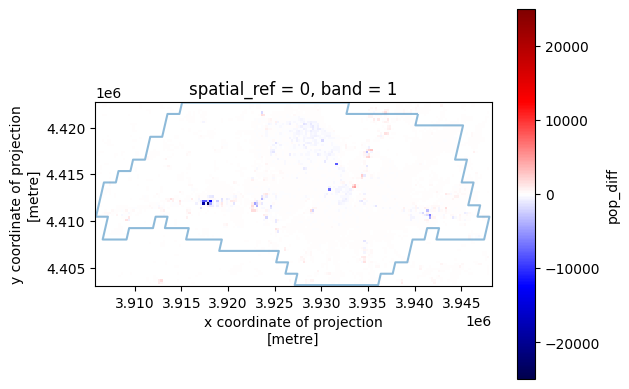

<Figure size 640x480 with 0 Axes>

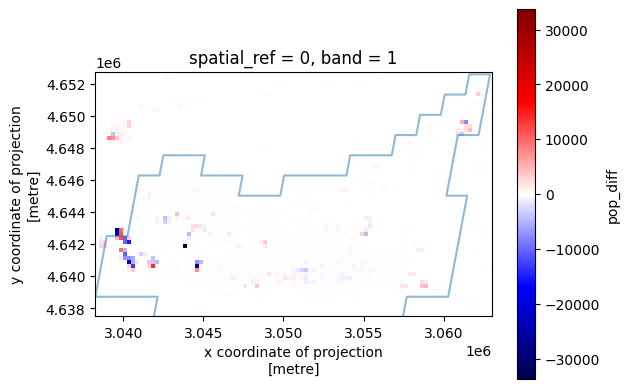

<Figure size 640x480 with 0 Axes>

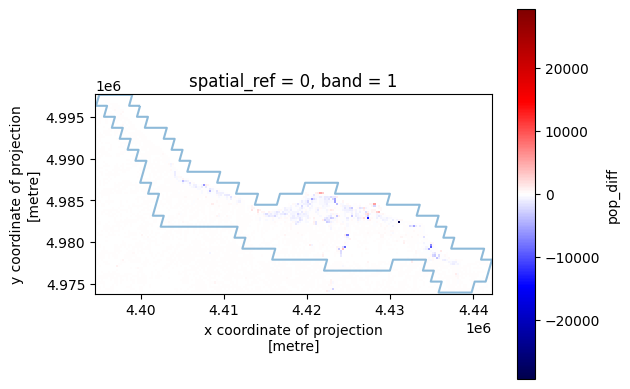

<Figure size 640x480 with 0 Axes>

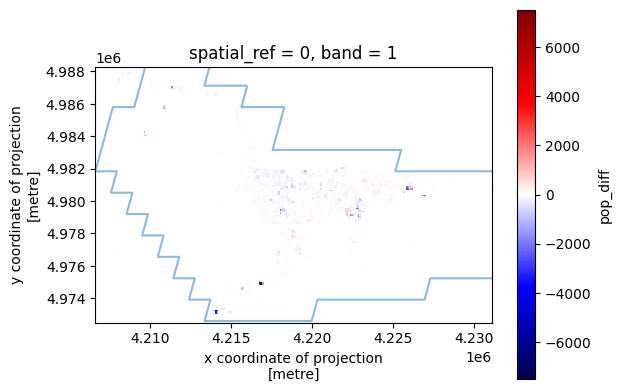

<Figure size 640x480 with 0 Axes>

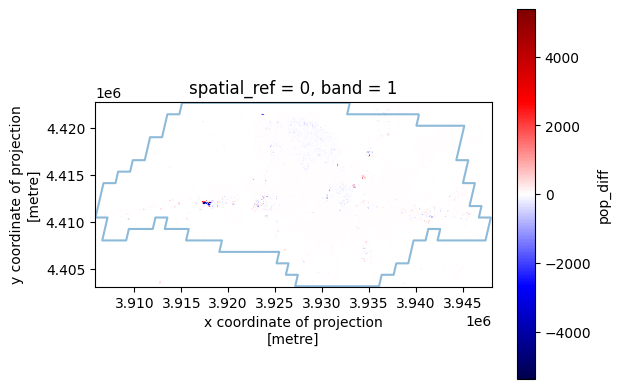

<Figure size 640x480 with 0 Axes>

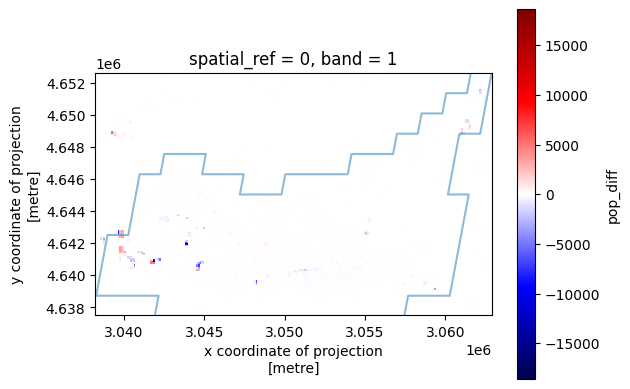

<Figure size 640x480 with 0 Axes>

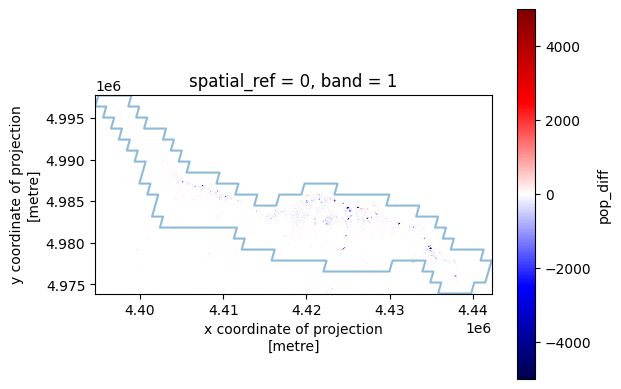

<Figure size 640x480 with 0 Axes>

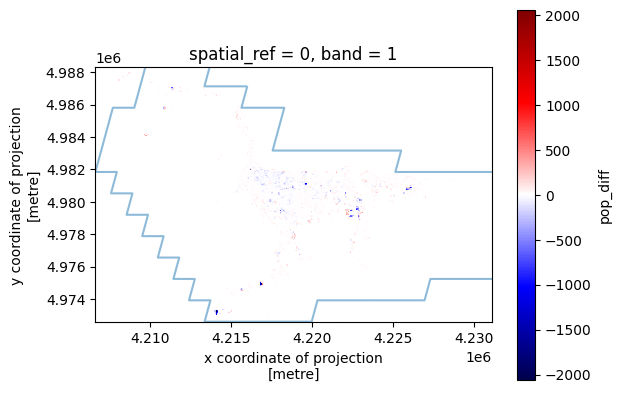

<Figure size 640x480 with 0 Axes>

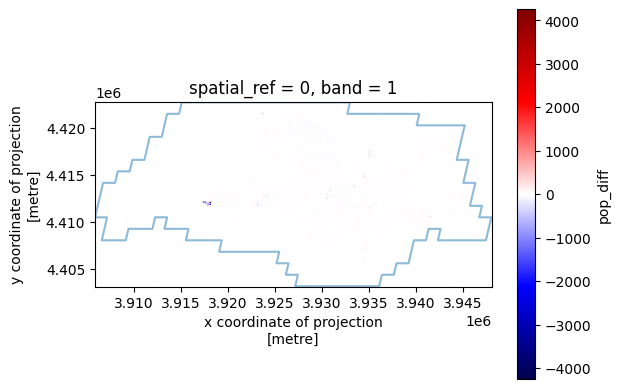

<Figure size 640x480 with 0 Axes>

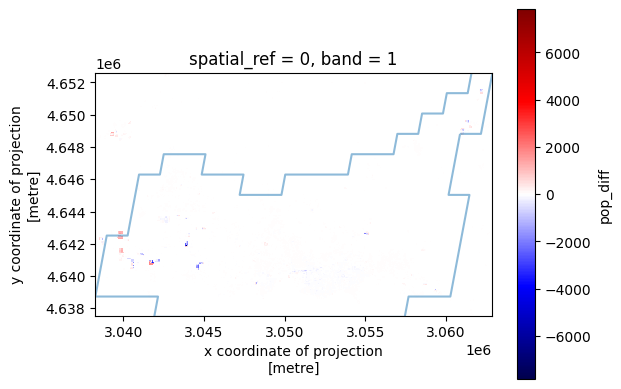

<Figure size 640x480 with 0 Axes>

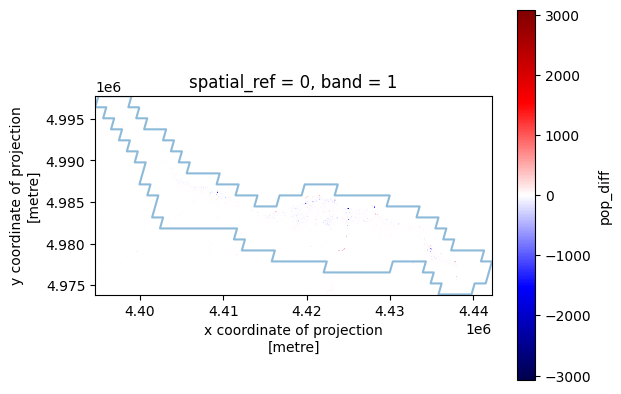

In [20]:
resolutions = [500, 250, 100, 50]
rmse = dict()
for r in resolutions:
    print(r, '\n')
    Cities = regions_from_cities(cities, r)
    for city in Cities:
        if city not in rmse:
            rmse[city]=[]
        # POP DIFF
        region = Cities[city]
        region.output = region.output.assign(pop_diff = region.output['pop_s'] - region.output['pop_v'])
        plt.figure()
        ax=region.vector['fua'].geo_df.exterior.plot(alpha=0.5)
        region.output.pop_diff.plot(ax=ax, cmap="seismic")
        # RMSE : every variable is set to a 1D array beforehand
        pop_s = np.nan_to_num(region.output['pop_s'].to_numpy()).ravel()
        pop_v = np.nan_to_num(region.output['pop_v'].to_numpy()).ravel()
        pop_rmse = np.sqrt(((pop_s - pop_v) ** 2).mean())
        rmse[city].append(pop_rmse / r)
        print(city, r, pop_rmse)

#### Relationship with NTL
We look at all cities at once, at 250 m resolution (NTL native one)

/tmp/ipykernel_38342/716502204.py:25: RuntimeWarning: divide by zero encountered in log
  ntl_v = np.log(ntl_v)


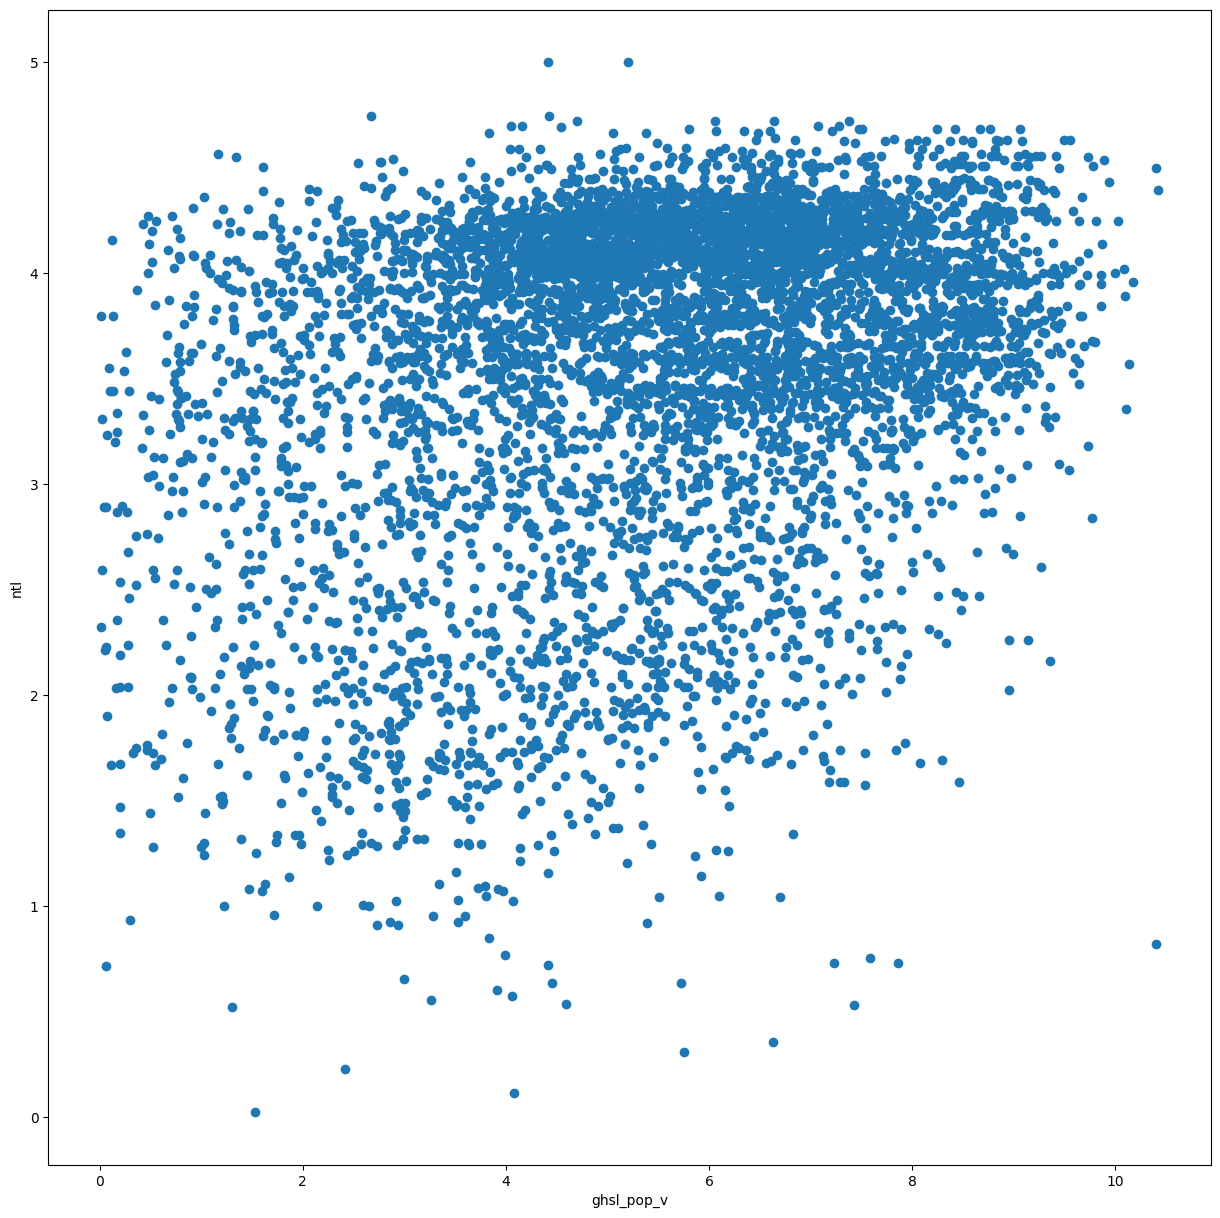

In [15]:
# NTL native resolution
resolutions = [250]
for r in resolutions:
    Cities = regions_from_cities(cities, r)
    pop_v = np.array([])
    ntl_v= np.array([])
    height_v= np.array([])
    surface_v = np.array([])
    
    for city in Cities:
        region = Cities[city]
        region.output = region.output.assign(ghsl_pop_v= pop_desaggregation_h)
        pop_v_tmp = np.nan_to_num(region.output['ghsl_pop_v'].to_numpy()).ravel()
        surface_tmp = np.nan_to_num(region.output['surface'].to_numpy()).ravel()
        ntl_tmp= np.nan_to_num(region.output['ntl'].to_numpy()).ravel()
        height_tmp= np.nan_to_num(region.output['height'].to_numpy()).ravel()

        # We need to filter the noise comming from unpopulated areas and population outlier :
        noisy_points_v = np.nonzero((pop_v_tmp > 1))[0]
        pop_v = np.append(pop_v,np.take(pop_v_tmp, noisy_points_v))
        ntl_v = np.append(ntl_v,np.take(ntl_tmp, noisy_points_v))
        height_v = np.append(height_v,np.take(height_tmp, noisy_points_v))
        surface_v = np.append(surface_v,np.take(surface_tmp, noisy_points_v))
    
    ntl_v = np.log(ntl_v)
    pop_v = np.log(pop_v)
    # Plot
    plt.figure(figsize=(15,15))
    plt.xlabel('ghsl_pop_v')
    plt.ylabel('ntl')
    plt.scatter(pop_v, ntl_v)

/tmp/ipykernel_38342/2292069675.py:24: RuntimeWarning: divide by zero encountered in log
  ntl_v = np.log(ntl_v)


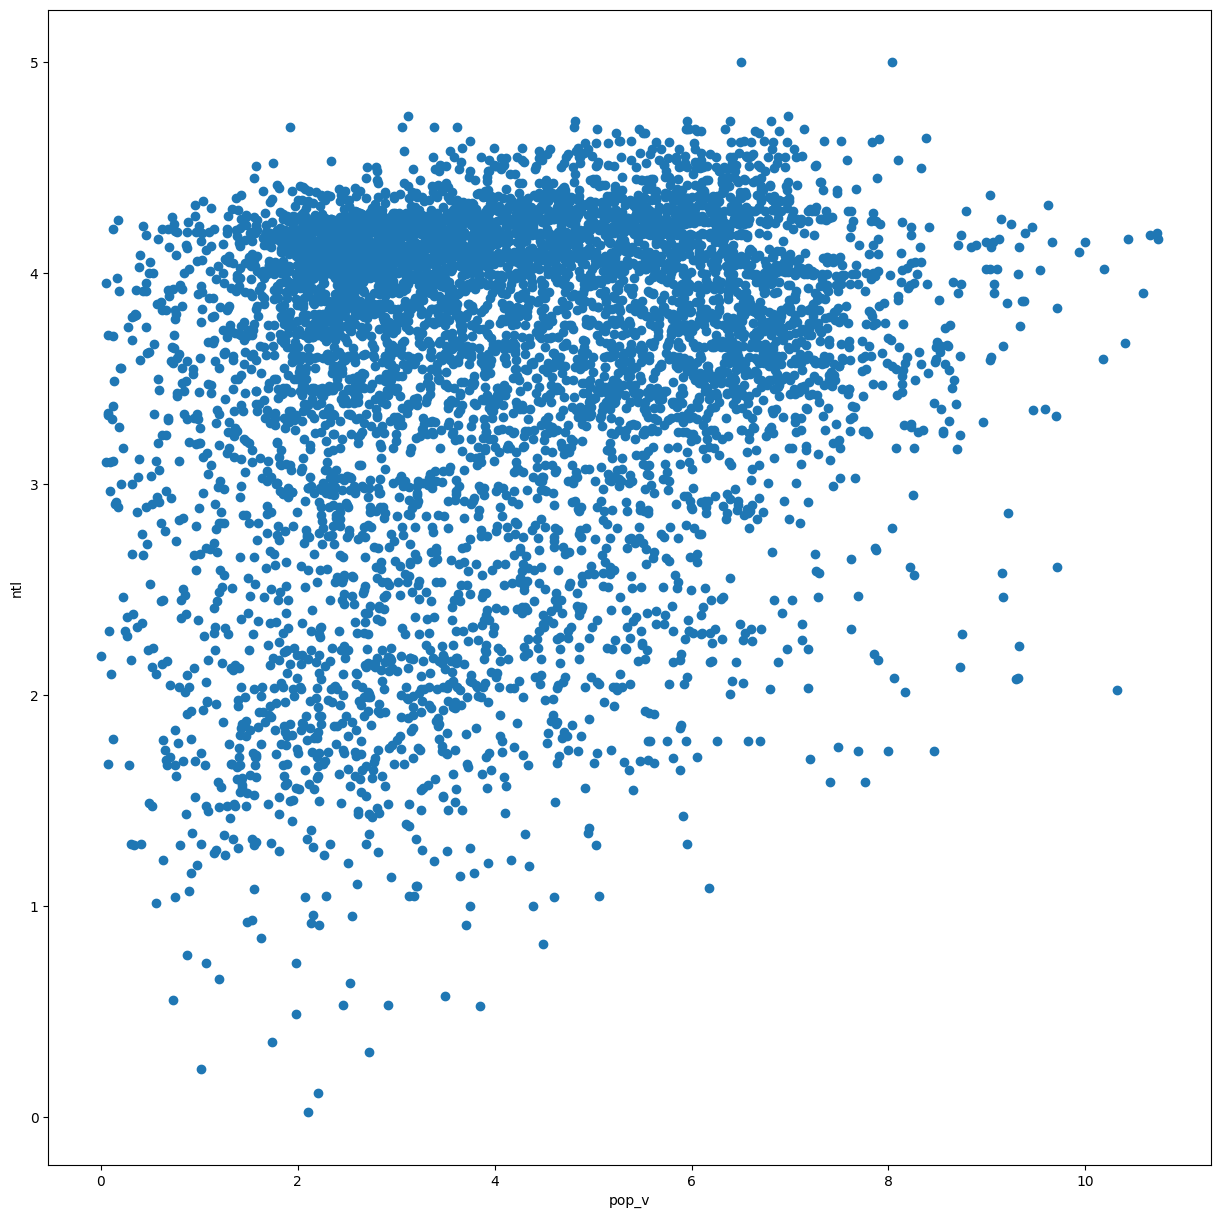

In [16]:
# NTL native resolution
resolutions = [250]
for r in resolutions:
    Cities = regions_from_cities(cities, r)
    pop_v = np.array([])
    ntl_v= np.array([])
    height_v= np.array([])
    surface_v = np.array([])

    for city in Cities:
        region = Cities[city]
        pop_v_tmp = np.nan_to_num(region.output['pop_v'].to_numpy()).ravel()
        surface_tmp = np.nan_to_num(region.output['surface'].to_numpy()).ravel()
        ntl_tmp= np.nan_to_num(region.output['ntl'].to_numpy()).ravel()
        height_tmp= np.nan_to_num(region.output['height'].to_numpy()).ravel()

        # We need to filter the noise comming from unpopulated areas and population outlier :
        noisy_points_v = np.nonzero((pop_v_tmp > 1))[0]
        pop_v = np.append(pop_v,np.take(pop_v_tmp, noisy_points_v))
        ntl_v = np.append(ntl_v,np.take(ntl_tmp, noisy_points_v))
        height_v = np.append(height_v,np.take(height_tmp, noisy_points_v))
        surface_v = np.append(surface_v,np.take(surface_tmp, noisy_points_v))
    
    ntl_v = np.log(ntl_v)
    pop_v = np.log(pop_v)
    # Plot
    plt.figure(figsize=(15,15))
    plt.xlabel('pop_v')
    plt.ylabel('ntl')
    plt.scatter(pop_v, ntl_v)